# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

class MyBinaryLogisticRegression:
  """
  Parameters
  ----------
  regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
       Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.
  weight_calc : {'gd', 'sgd', 'newton'}, default='gd'
       Каким образом вычислять вектор весов: градиентным спуском ('gd'), стохастическим градиентным спуском ('sgd') или методом Ньютона ('newton').
       При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'newton'.

  Attributes
  ---------
  coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
  feature_names_in_ : Вектор имен признаков
  """
  def __init__(self, regularization=None, weight_calc='gd', lambda_1=None, lambda_2=None, batch_size=20, random_state=42, max_iter=1000, learning_rate=0.05, early_stopping=0.0001):
      if regularization not in [None, 'l1', 'l2', 'l1l2']:
        raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
      if weight_calc not in ['gd', 'sgd', 'newton']:
        raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
      if regularization in ['l1', 'l1l2'] and lambda_1 is None:
        raise TypeError(f"Значение коэффициента регулризации l1 не задано")
      if regularization in ['l2', 'l1l2'] and lambda_2 is None:
        raise TypeError(f"Значение коэффициента регулризации l2 не задано")
      if regularization in ['l1', 'l1l2'] and weight_calc == 'newton':
        raise TypeError(f"Параметр weight_calc не может принимать значение 'newton' при регуляризации'{regularization}'")

      self.regularization = regularization
      self.weight_calc = weight_calc
      self.lambda_1 = lambda_1
      self.lambda_2 = lambda_2
      self.batch_size = batch_size
      self.random_state = random_state
      self.max_iter = max_iter
      self.learning_rate = learning_rate
      self.early_stopping = early_stopping

      self.coefs_ = None
      self.feature_names_in_ = None

  def get_sigmoid(self, X,W):
    return 1/(1+np.exp(-X @ W))

  def get_grad(self, X,Y,W):
    return X.T @ (self.get_sigmoid(X,W)-Y)

  def fit(self, X: pd.DataFrame, y: pd.DataFrame):
      X = X.values
      y = y.values

      X = np.concatenate(([[1]]*X.shape[0], X), axis=1)

      np.random.seed(self.random_state)
      omega = np.random.uniform(0, 0, X.shape[1])

      for _ in range(self.max_iter):
        if self.weight_calc == 'gd':
          grad = self.get_grad(X, y, omega)
          if self.regularization in ['l1', 'l1l2']:
            grad[1:] += self.lambda_1*np.sign(omega[1:])
          if self.regularization in ['l2', 'l1l2']:
            grad[1:] += self.lambda_2*omega[1:]
          omega -= self.learning_rate*grad
          if np.linalg.norm(grad) < self.early_stopping:
            break

        elif self.weight_calc == 'sgd':
          stop = False
          indices = np.random.permutation(X.shape[0])
          X_shuffled = X[indices]
          y_shuffled = y[indices]
          for j in range(0, X.shape[0], self.batch_size):
            grad = self.get_grad(X_shuffled[j:j+self.batch_size], y_shuffled[j:j+self.batch_size], omega)
            if self.regularization in ['l1', 'l1l2']:
              grad[1:] += self.lambda_1*np.sign(omega[1:])
            if self.regularization in ['l2', 'l1l2']:
              grad[1:] += self.lambda_2*omega[1:]
            omega -= self.learning_rate*grad
            if np.linalg.norm(grad) < self.early_stopping:
              stop = True
              break
          if stop:
            break

        elif self.weight_calc == 'newton':
          hess = X.T @ np.diag((self.get_sigmoid(X, omega))*(1-self.get_sigmoid(X, omega))) @ X
          grad = self.get_grad(X, y, omega)
          if self.regularization == 'l2':
            grad[1:] += self.lambda_2*omega[1:]
            hess[1:, 1:] += self.lambda_2*np.eye(len(omega[1:]))
          eps = 1e-6
          hess += eps * np.eye(hess.shape[0])
          delta = np.linalg.solve(hess, -grad)
          omega += delta
          if np.linalg.norm(delta) < self.early_stopping:
            break

      self.coefs_ = omega
      return self


  def predict(self, X: np.array):
    X = np.concatenate(([[1]]*X.shape[0], X), axis=1)
    predictions = (self.get_sigmoid(X, self.coefs_)>=0.5).astype(int)
    return predictions

  def score(self, X: np.array, y: np.array):
    y_pred = self.predict(X)
    return f1_score(y, y_pred)

Регуляризация l2 является дважды дифференцируемой функцией, поэтому для неё применимы все три метода оптимизации.

Регулярищация l1 недиффеенцируема в нуле, но можно использовать субградиет, поэтому градиентный спуск и стохастический градиентный спуск применимы, но метод Ньютона не применим, потому что l1 не имеет второй производной.

Для регуляризации l1l2 соответственно применимы градиентный спуск и стохастический градиентный спуск, а метод Ньютона не применим.

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ML/penguins_binary_classification.csv')
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007


Закодируем целевую переменную-вид пингвина как Adelie-0, Gentoo-1 с помощью `LabelEncoder`:

In [107]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['species'])

df['species'] = le.transform(df['species'])
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,0,Torgersen,39.1,18.7,181.0,3750.0,2007
1,0,Torgersen,39.5,17.4,186.0,3800.0,2007
2,0,Torgersen,40.3,18.0,195.0,3250.0,2007
3,0,Torgersen,36.7,19.3,193.0,3450.0,2007
4,0,Torgersen,39.3,20.6,190.0,3650.0,2007


Реализуем преобразование `Target Encoder` для категориального признака island:

In [100]:
encoding = df['species'].groupby(df['island']).mean().to_dict()
df['island'] = df['island'].map(encoding)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,0,0.000000,39.1,18.7,181.0,3750.0,2007
1,0,0.000000,39.5,17.4,186.0,3800.0,2007
2,0,0.000000,40.3,18.0,195.0,3250.0,2007
3,0,0.000000,36.7,19.3,193.0,3450.0,2007
4,0,0.000000,39.3,20.6,190.0,3650.0,2007
...,...,...,...,...,...,...,...
269,1,0.736527,47.2,13.7,214.0,4925.0,2009
270,1,0.736527,46.8,14.3,215.0,4850.0,2009
271,1,0.736527,50.4,15.7,222.0,5750.0,2009
272,1,0.736527,45.2,14.8,212.0,5200.0,2009


Выполним нормализацию:

In [101]:
X = df.drop('species', axis=1)
y = df['species']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,-1.249299,-0.694729,0.927421,-1.410000,-0.680802,-1.296949
1,-1.249299,-0.617600,0.280569,-1.077120,-0.620879,-1.296949
2,-1.249299,-0.463341,0.579116,-0.477937,-1.280031,-1.296949
3,-1.249299,-1.157507,1.225969,-0.611089,-1.040339,-1.296949
4,-1.249299,-0.656165,1.872821,-0.810817,-0.800648,-1.296949


Разделим на обучающую и тестовую выборки:

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['species'])

Продемонстрируем применение реализованного класса и рассмотрим все возможные варианты (регуляризация/оптимизация):

In [103]:
weight_calcs = ['gd', 'sgd', 'newton']
regularizations = [None, 'l1', 'l2','l1l2']
lambda_ = [0.1, 1.0, 10.0]

In [104]:
import itertools
results = []
encoding = 'target'

for weight_calc, reg in itertools.product(weight_calcs,regularizations):
  lam1 = 0
  lam2 = 0
  if reg == 'l1' and weight_calc != 'newton':
    for lam1 in lambda_:
      MyLogreg = MyBinaryLogisticRegression(weight_calc=weight_calc, regularization=reg, lambda_1=lam1, lambda_2=lam2).fit(X_train, y_train)
      score = np.round(MyLogreg.score(X_test.values, y_test.values),4)
      results.append([encoding, weight_calc, reg, lam1, lam2, score])
  elif reg == 'l2':
    for lam2 in lambda_:
      MyLogreg = MyBinaryLogisticRegression(weight_calc=weight_calc, regularization=reg, lambda_1=lam1, lambda_2=lam2).fit(X_train, y_train)
      score = np.round(MyLogreg.score(X_test.values, y_test.values),4)
      results.append([encoding, weight_calc, reg, lam1, lam2, score])
  elif reg == 'l1l2' and weight_calc != 'newton':
    for lam1 in lambda_:
      for lam2 in lambda_:
        if lam1!=lam2:
          MyLogreg = MyBinaryLogisticRegression(weight_calc=weight_calc, regularization=reg, lambda_1=lam1, lambda_2=lam2).fit(X_train, y_train)
          score = np.round(MyLogreg.score(X_test.values, y_test.values),4)
          results.append([encoding, weight_calc, reg, lam1, lam2, score])

In [105]:
pd.DataFrame(results, columns = ['encoding', 'weight_calc', 'regularization', 'lambda_1', 'lambda_2', 'f1_score'])

,encoding,weight_calc,regularization,lambda_1,lambda_2,f1_score
0,target,gd,l1,0.1,0.0,1.0000
1,target,gd,l1,1.0,0.0,1.0000
2,target,gd,l1,10.0,0.0,1.0000
3,target,gd,l2,0.0,0.1,1.0000
4,target,gd,l2,0.0,1.0,1.0000
5,target,gd,l2,0.0,10.0,1.0000
6,target,gd,l1l2,0.1,1.0,1.0000
7,target,gd,l1l2,0.1,10.0,1.0000
8,target,gd,l1l2,1.0,0.1,1.0000
9,target,gd,l1l2,1.0,10.0,1.0000


Теперь закодируем категориальный признак island с помощью `one-hot`:

In [108]:
df = pd.get_dummies(df, columns=['island'], drop_first=True, dtype=float)
df.head(5)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen
0,0,39.1,18.7,181.0,3750.0,2007,0.0,1.0
1,0,39.5,17.4,186.0,3800.0,2007,0.0,1.0
2,0,40.3,18.0,195.0,3250.0,2007,0.0,1.0
3,0,36.7,19.3,193.0,3450.0,2007,0.0,1.0
4,0,39.3,20.6,190.0,3650.0,2007,0.0,1.0


Выполним нормализацию:

In [109]:
X = df.drop('species', axis=1)
y = df['species']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen
0,-0.694729,0.927421,-1.410000,-0.680802,-1.296949,-0.506834,2.091064
1,-0.617600,0.280569,-1.077120,-0.620879,-1.296949,-0.506834,2.091064
2,-0.463341,0.579116,-0.477937,-1.280031,-1.296949,-0.506834,2.091064
3,-1.157507,1.225969,-0.611089,-1.040339,-1.296949,-0.506834,2.091064
4,-0.656165,1.872821,-0.810817,-0.800648,-1.296949,-0.506834,2.091064


Разделим на обучающую и тестовую выборки:

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['species'])

Продемонстрируем применение реализованного класса и рассмотрим все возможные варианты (регуляризация/оптимизация):

In [111]:
import itertools
results = []
encoding = 'one-hot'

for weight_calc, reg in itertools.product(weight_calcs,regularizations):
  lam1 = 0
  lam2 = 0
  if reg == 'l1' and weight_calc != 'newton':
    for lam1 in lambda_:
      MyLogreg = MyBinaryLogisticRegression(weight_calc=weight_calc, regularization=reg, lambda_1=lam1, lambda_2=lam2).fit(X_train, y_train)
      score = np.round(MyLogreg.score(X_test.values, y_test.values),3)
      results.append([encoding, weight_calc, reg, lam1, lam2, score])
  elif reg == 'l2':
    for lam2 in lambda_:
      MyLogreg = MyBinaryLogisticRegression(weight_calc=weight_calc, regularization=reg, lambda_1=lam1, lambda_2=lam2).fit(X_train, y_train)
      score = np.round(MyLogreg.score(X_test.values, y_test.values),3)
      results.append([encoding, weight_calc, reg, lam1, lam2, score])
  elif reg == 'l1l2' and weight_calc != 'newton':
    for lam1 in lambda_:
      for lam2 in lambda_:
        if lam1!=lam2:
          MyLogreg = MyBinaryLogisticRegression(weight_calc=weight_calc, regularization=reg, lambda_1=lam1, lambda_2=lam2).fit(X_train, y_train)
          score = np.round(MyLogreg.score(X_test.values, y_test.values),3)
          results.append([encoding, weight_calc, reg, lam1, lam2, score])

In [112]:
pd.DataFrame(results, columns = ['encoding', 'weight_calc', 'regularization', 'lambda_1', 'lambda_2', 'f1_score'])

,encoding,weight_calc,regularization,lambda_1,lambda_2,f1_score
0,one-hot,gd,l1,0.1,0.0,1.000
1,one-hot,gd,l1,1.0,0.0,1.000
2,one-hot,gd,l1,10.0,0.0,1.000
3,one-hot,gd,l2,0.0,0.1,1.000
4,one-hot,gd,l2,0.0,1.0,1.000
5,one-hot,gd,l2,0.0,10.0,1.000
6,one-hot,gd,l1l2,0.1,1.0,1.000
7,one-hot,gd,l1l2,0.1,10.0,1.000
8,one-hot,gd,l1l2,1.0,0.1,1.000
9,one-hot,gd,l1l2,1.0,10.0,1.000


# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

1. Функция потерь

Правдоподобие:
$$L(\omega)=\prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.$$

Логарифм правдоподобия:
$$l(\omega) = \sum_{i = 1}^{N}\sum_{j = 1}^M {y_{ij}} ln(\mathbb P(C_j|x_i))=\sum_{i = 1}^{N}\sum_{j = 1}^M {y_{ij}} (\omega_j^Tx_i-ln\sum_{k=1}^{M}exp(\omega_k^Tx_i)).$$

Минимизируем отрицательное логарифмическое правдоподобие:
$$J(\omega) = -l(\omega) =\sum_{i = 1}^{N}\sum_{j = 1}^M {y_{ij}} (\omega_j^Tx_i-ln\sum_{k=1}^{M}exp(\omega_k^Tx_i))\underset{w}\longrightarrow \min$$

2. Градиент
$$\frac{\partial J}{\partial \omega_l}=-\sum_{i=1}^{N}y_{il}x_i-p_{il}x_i=-\sum_{i=1}^{N}(y_{il}-p_{il})x_i$$

Тогда в матричной форме
$$\nabla_{\omega} J(\omega)=-X^T(Y-P).$$

3. Гессиан
$$\frac{\partial^2 J}{\partial \omega_l\omega_s}=\sum_{i=1}^{N} \frac{\partial}{\partial \omega_s}(p_{il}x_i)=\sum_{i=1}^{N}p_{il}(δ_{ls}-p_{is})x_ix_i^T,$$

где $δ_{ls}=1$, если $l=s$, иначе $δ_{ls}=0$.

Тогда в матричной форме
$$H = X^TDX,$$
где матрица D с элементами $p_{il}(δ_{ls}-p_{is})$.


In [ ]:
def softmax(X, W):
  return np.exp(X.dot(W))/np.sum(np.exp(X.dot(W)), axis=1, keepdims=True)

def get_grad(X, Y, W):
  return -X.T.dot((Y-softmax(X, W)))

def predict(X, W):
  return np.argmax(softmax(X, W), axis=1)

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, random_state=23)

Y = pd.get_dummies(y, dtype=float)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

M = 3
N, f = X.shape
lr = 0.01

W = np.random.uniform(-0.01, 0.01, (f, M))

for i in range(1000):
  grad = get_grad(X, Y, W)
  W -= lr*grad

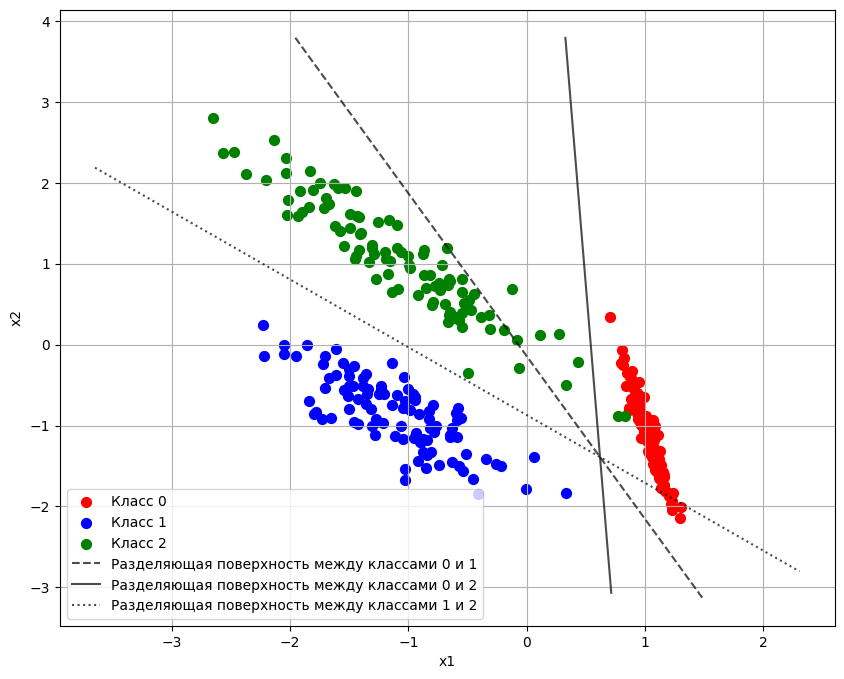

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
color = ['red', 'blue', 'green']
style = ['--', '-', ':']
for i in range(M):
  plt.scatter(X[y==i, 1], X[y==i, 2], c=color[i], label=f'Класс {i}', s=50)

for i in range(M):
  for j in range(i+1, M):
    w_diff = W[:, i] - W[:, j]
    x1_vals = np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 1000)
    x2_vals = -(w_diff[0] + w_diff[1]*x1_vals) / w_diff[2]
    mask = (x2_vals >= X[:, 2].min()-1) & (x2_vals <= X[:, 2].max()+1)
    plt.plot(x1_vals[mask], x2_vals[mask], style[i+j-1], c='black', label=f'Разделяющая поверхность между классами {i} и {j}', linewidth=1.5, alpha=0.7)
plt.legend(loc='lower left')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

Для объекта $x_i$ многоклассовая логистическая регрессия вычисляет для каждого класса скор - линейную функцию $z_{ij} = \omega_j^Tx_i$.

Затем преобразует их с помощью softmax в вероятность $\mathbb P(C_j|x_i) = \frac{\exp(\omega_j^Tx_i)}{\sum_{k=1}^M \exp(\omega_k^Tx_i)}.$

Каждый объект $x_i$ относится к тому классу, для которого максимальна вероятность.

Граница между двумя классами $j$ и $k$ определяется уравнением $\omega_j^Tx_i=\omega_k^Tx_i$.

В двумерном случае это прямая линия. В многомерном простанстве признаков - гиперплоскость.